In [3]:
import pandas as pd
import numpy as np
import re
import glob
from pathlib import Path
from captum.attr import IntegratedGradients
from NegativeClassOptimization.preprocessing import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pathlib import Path
import torch
import torch.nn as nn
import pandas as pd
from captum.attr import IntegratedGradients
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Finding correct mutants

In [4]:
#get number of mutations from ID
def get_mutations(ID):
    try:
        n_mut = re.search('([0-9])m',ID).group(1)
        return int(n_mut)
    except:
        return np.NaN

In [5]:
def find_ids(ID):
    try:
        first_id = re.match('[A-Z_]*([0-9]+_[0-9]*[a-z])',ID).group(1)
        return first_id
    except:
        return 'unknown'

In [11]:
def prep_mut_df(mut_folder):
    mut_file = pd.read_csv(mut_path / f'{mut_folder}/PooledTempResults_merged.txt', sep=' ')
    mut_file['n_mut'] = mut_file['ID_slide_Variant'].apply(get_mutations)
    mut_file['ID'] = mut_file['ID_slide_Variant'].apply(find_ids)
    return mut_file

In [16]:
# find mutated slides corresponding to slides from test set
def get_org_slide_id(mut_file, wt_path):
    wt_file = pd.read_csv(wt_path, sep='\t')
    wt_test = wt_file[wt_file['y'] == 1] 
    wt_slides = set(wt_test.Slide)
    int_slides = set(mut_file[mut_file['n_mut'] == 0]['Slide']).intersection(wt_slides)
    slide_id = mut_file[mut_file['Slide'].isin(int_slides) & (mut_file['n_mut']==0)][['Slide', 'ID', 'Energy']]
    return slide_id

In [82]:
# in the simulation a mutattion is also a shift in 11 mer, this function finds point mutations without changing the 11mer
def get_mut_patterns(slide):
    ex_slide_list = list(slide)
    mut_patterns = []
    for i in range(11):
        mut_pattern = ex_slide_list[:i] + [f'[^{ex_slide_list[i]}]']
        if i < 10:
            mut_pattern = mut_pattern + ex_slide_list[i+1:]
        mut_patterns.append(((i),''.join(mut_pattern)))
    return mut_patterns

In [83]:
def ig_from_oh(oh_slide,ig,baseline):
    oh_slide = np.array(oh_slide)
    oh_slide = torch.tensor(oh_slide).float()
    attr = ig.attribute(oh_slide, baseline)
    attr = attr.squeeze()
    attr = attr.reshape(11, -1)
    attr = attr.detach().numpy()
    aa_attr = list(map(sum, attr))
    return aa_attr

In [84]:
def mutant_ig(ig,mut_file, slide_id, n_mut=1):
    dfs_list = []
    for slide, ID, Energy in  slide_id.values:
        mut_patterns = get_mut_patterns(slide) #needed so there is no shift in Slide
        df_search = mut_file[(mut_file['ID'] == ID) & (mut_file['n_mut']==n_mut) & (mut_file['Slide']!=slide)].copy(deep=True)
        df_search['original Slide'] = slide
        org_slide_oh = torch.tensor(np.array([[onehot_encode(slide)]])).float()
        df_search['IG org'] = [ig_from_oh(org_slide_oh, ig, baseline)]*df_search.shape[0]
        df_search['Energy org'] = [Energy]*df_search.shape[0]

        for i, pattern in mut_patterns:
            df_pos_mut = df_search[df_search['Slide'].str.contains(pattern)].copy(deep=True)
            df_pos_mut['mut OH'] = df_pos_mut['Slide'].apply(lambda x: [[onehot_encode(x)]])
            df_pos_mut['IG mut'] = df_pos_mut['mut OH'].apply(lambda x: ig_from_oh(x,ig,baseline))
            df_pos_mut['posn IG mut'] = df_pos_mut['IG mut'].apply(lambda x: x[i])
            df_pos_mut['posn IG org'] = df_pos_mut['IG org'].apply(lambda x: x[i])
            df_pos_mut['posn delta IG'] =  df_pos_mut['posn IG org'] - df_pos_mut['posn IG mut']
            df_pos_mut['dEnergy'] = [Energy]*df_pos_mut.shape[0] - df_pos_mut['Energy']
            dfs_list.append(df_pos_mut)
    return pd.concat(dfs_list)

## Finding best model

In [103]:
#open and closed performances
perf_df = pd.read_csv('../data/openset_performance.tsv', sep='\t')
perf_df[['train_task', 'train_ag', 'train_neg', 'seed_id', 'split_id']] = perf_df.task_1.str.split('__', expand=True)
perf_df[['test_task', 'test_ag', 'test_neg', 'test_seed_id', 'test_split_id']] = perf_df.task_2.str.split('__', expand=True)
perf_df.drop(['task_1', 'task_2'], inplace=True, axis=1)

In [101]:
#choose the best model in terms of closed performance
def get_best_model_seed_split(df, train_task, test_task, ag, metric):
    task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]
    best_row = task_df[task_df['acc'] == task_df['acc'].max()]
    seed_id = best_row['seed_id'].values[0]
    split_id = best_row['split_id'].values[0]
    return seed_id , split_id

In [102]:
tasks = ['ONE_VS_NINE', 'HIGH_VS_95LOW', 'HIGH_VS_LOOSER']
tasks_dict = {'ONE_VS_NINE': '1v9', 'HIGH_VS_95LOW': 'high_vs_95low', 'HIGH_VS_LOOSER': 'high_vs_looser'}
task_template = {'ONE_VS_NINE': '{ag}__vs__9', 'HIGH_VS_95LOW': '{ag}_high__vs__{ag}_95low', 'HIGH_VS_LOOSER': '{ag}_high__vs__{ag}_looser'}

# Plotting

In [107]:
def single_mut_plot(df, task, pic_name):
    color = get_color(task)
    g = sns.scatterplot(df, x = 'posn delta IG', y='dEnergy', s=20, color = color)
    g.set(xlabel='Δ Energy', ylabel='Δ position IG')
    #g.set(title='loose binders')
    plt.savefig(f'./plots/{pic_name}.png')
    plt.show()

In [108]:
def get_corr(df, columns):
    for column in columns:
        df[column] = pd.to_numeric(df[column])
    pers_corr = df[columns].corr().iloc[0,1]
    pers_corr = round(pers_corr,2)
    return pers_corr

In [109]:
def get_color(task):
    if task == 'ONE_VS_NINE' :
        color= '#ababab'
    elif task == 'HIGH_VS_95LOW':
        color = '#5CA7E5'
    else:
        color = '#ff7700'
    return color

## Get degree of mutated amino-acid

## Example

In [110]:
baseline = torch.tensor([[[0.0]*220]])

In [111]:
mut_path = Path('../data/mutated_t6')

In [112]:
mut_file_1nsn = prep_mut_df('1NSN')

In [113]:
wt_path = glob.glob('./torch_models/Frozen_MiniAbsolut_ML/1v9/seed_0/split_0/1NSN__vs__9/*_test_dataset.tsv')[0]

In [114]:
slide_id_1nsn = get_org_slide_id(mut_file_1nsn, wt_path)


In [115]:
slide_id_1nsn.shape

(21, 3)

In [116]:
task = 'HIGH_VS_LOOSER'
ag = '1NSN'

In [117]:
seed_id, split_id = get_best_model_seed_split(perf_df, task, task, ag, 'acc')

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_12180/1886023973.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_df = df[df['train_task'] == train_task][df['test_task'] == test_task][df['train_ag'] == ag]


In [118]:
model_path = f"./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[task]}/seed_{seed_id}/split_{split_id}/{task_template[task].format(ag=ag)}/swa_model/data/model.pth"
model = torch.load(model_path, map_location=torch.device('cpu'))

In [119]:
ig = IntegratedGradients(model.cpu())

In [120]:
mut_1nsn_igs = mutant_ig(ig,mut_file_1nsn, slide_id_1nsn)

In [121]:
mut_1nsn_igs.shape

(3047, 17)

FileNotFoundError: [Errno 2] No such file or directory: './plots/mut_1nsn_loos_igs.png'

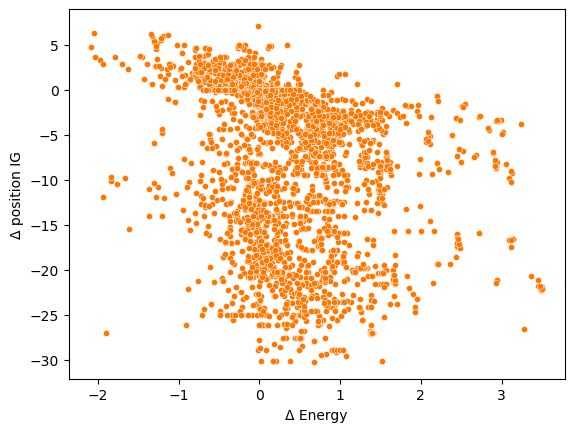

In [122]:
single_mut_plot(mut_1nsn_igs, task, 'mut_1nsn_loos_igs')

In [68]:
get_corr(mut_1adq_loos_igs,['posn delta IG', 'dEnergy'])

-0.46

In [80]:
def get_2mut_patterns(slide):
    ex_slide_list = list(slide)
    mut_patterns = []
    for i in range(10):
        for j in range(i+1,11):
            mut_pattern = ex_slide_list[:i] + [f'[^{ex_slide_list[i]}]'] + ex_slide_list[i+1:j] + [f'[^{ex_slide_list[j]}]']
            if j < 10:
                mut_pattern = mut_pattern + ex_slide_list[j+1:]  
            mut_patterns.append(((i,j),''.join(mut_pattern)))
    return mut_patterns

In [81]:
def mutant2_ig(ig,mut_file, slide_id, n_mut=1):
    dfs_list = []
    for slide, ID, Energy in  slide_id.values:
        mut_patterns = get_2mut_patterns(slide) #needed so there is no shift in Slide
        df_search = mut_file[(mut_file['ID'] == ID) & (mut_file['n_mut']==n_mut) & (mut_file['Slide']!=slide)].copy(deep=True)
        df_search['original Slide'] = slide
        org_slide_oh = torch.tensor(np.array([[onehot_encode(slide)]])).float()
        df_search['IG org'] = [ig_from_oh(org_slide_oh, ig, baseline)]*df_search.shape[0]
        df_search['Energy org'] = [Energy]*df_search.shape[0]

        for (i, j), pattern in mut_patterns:
            df_pos_mut = df_search[df_search['Slide'].str.contains(pattern)].copy(deep=True)
            df_pos_mut['mut OH'] = df_pos_mut['Slide'].apply(lambda x: [[onehot_encode(x)]])
            df_pos_mut['IG mut'] = df_pos_mut['mut OH'].apply(lambda x: ig_from_oh(x,ig,baseline))
            df_pos_mut['posn IG mut1'] = df_pos_mut['IG mut'].apply(lambda x: x[i])
            df_pos_mut['posn IG mut2'] = df_pos_mut['IG mut'].apply(lambda x: x[j])
            df_pos_mut['posn IG org1'] = df_pos_mut['IG org'].apply(lambda x: x[i])
            df_pos_mut['posn IG org2'] = df_pos_mut['IG org'].apply(lambda x: x[j])
            df_pos_mut['posn1 delta IG'] =  df_pos_mut['posn IG org1'] - df_pos_mut['posn IG mut1']
            df_pos_mut['posn2 delta IG'] =  df_pos_mut['posn IG org2'] - df_pos_mut['posn IG mut2']
            df_pos_mut['dEnergy'] = [Energy]*df_pos_mut.shape[0] - df_pos_mut['Energy']
            dfs_list.append(df_pos_mut)
    return pd.concat(dfs_list)

In [82]:
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_path = f'./torch_models/SN10_1_vs_all/1NSN_vs_all_repl_10_swa.pt'
swa_model.load_state_dict(torch.load(model_path))
swa_model = swa_model.to('cpu')
ig = IntegratedGradients(swa_model.cpu())
mut2_1nsn_igs = mutant2_ig(ig,mut_file_1nsn, slide_id_1nsn, n_mut=2)

In [83]:
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_path = f'./torch_models/SN10_1_vs_all/1ADQ_vs_all_repl_10_swa.pt'
swa_model.load_state_dict(torch.load(model_path))
swa_model = swa_model.to('cpu')
ig = IntegratedGradients(swa_model.cpu())
mut2_1adq_igs = mutant2_ig(ig,mut_file_1adq, slide_id_1adq, n_mut=2)

In [84]:
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_path = f'./torch_models/SN10_high_low/1ADQ_high_looser_repl_10_swa.pt'
swa_model.load_state_dict(torch.load(model_path))
swa_model = swa_model.to('cpu')
ig = IntegratedGradients(swa_model.cpu())
mut2_1adq_loos_igs= mutant2_ig(ig,mut_file_1adq, slide_id_1adq, n_mut=2)

In [85]:
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_path = f'./torch_models/SN10_high_low/1NSN_high_looser_repl_10_swa.pt'
swa_model.load_state_dict(torch.load(model_path))
swa_model = swa_model.to('cpu')
ig = IntegratedGradients(swa_model.cpu())
mut2_1nsn_loos_igs= mutant2_ig(ig,mut_file_1nsn, slide_id_1nsn, n_mut = 2)

In [86]:
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_path = f'./torch_models/SN10_high_low/1NSN_high_95low_repl_10_swa.pt'
swa_model.load_state_dict(torch.load(model_path))
swa_model = swa_model.to('cpu')
ig = IntegratedGradients(swa_model.cpu())
mut2_1nsn_low_igs= mutant2_ig(ig,mut_file_1nsn, slide_id_1nsn, n_mut = 2)

In [87]:
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_path = f'./torch_models/SN10_high_low/1ADQ_high_95low_repl_10_swa.pt'
swa_model.load_state_dict(torch.load(model_path))
swa_model = swa_model.to('cpu')
ig = IntegratedGradients(swa_model.cpu())
mut2_1adq_low_igs= mutant2_ig(ig,mut_file_1adq, slide_id_1adq, n_mut=2)

In [88]:
mut_1nsn_igs.columns

Index(['ID_slide_Variant', 'CDR3', 'Best', 'Slide', 'Energy', 'Structure',
       'n_mut', 'ID', 'original Slide', 'IG org', 'Energy org', 'mut OH',
       'IG mut', 'posn IG mut', 'posn IG org', 'posn delta IG', 'dEnergy'],
      dtype='object')

In [94]:
def get_3D_2mut_plot(df, pic_name):
    color = get_color(pic_name)
    for i, (a1, a2) in enumerate([(180,20),(90,0),(180,0)]): #(180,30),(90,30) #(45,90),(0,0), (90,0)
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(df['posn1 delta IG'], df['posn2 delta IG'], df['dEnergy'], color=color, alpha=1, s=5)
        ax.set_zlabel('Δ Energy')
        if i <= 1:
            ax.set_xlabel('Δ p1 IG')
        else:
            ax.set_xlabel('')
        if i !=1:
            ax.set_ylabel('Δ p2 IG')
        else:
            ax.set_ylabel('')
        # rotate the axes and update
        ax.view_init(a2, a1)
        fig.tight_layout() #reg_coef[], reg_coef
        plt.savefig(f'./plots/{pic_name}_3D_{a2}_{a1}.png', bbox_inches = 'tight')
        plt.show()


In [95]:
#low color = '#1f78b4'
#1 vs all color = '#a6cee3'
#loose color='#b2df8a'

In [96]:
print(get_corr(mut2_1adq_loos_igs,['posn1 delta IG', 'dEnergy']))
print(get_corr(mut2_1adq_loos_igs,['posn2 delta IG', 'dEnergy']))

-0.31
-0.31


In [97]:
reg = LinearRegression()
X = mut2_1adq_loos_igs[['posn1 delta IG', 'posn2 delta IG']]
y = mut2_1adq_loos_igs['dEnergy']
reg.fit(X,y)
print(reg.coef_)

[-12.17339576 -12.23119589]


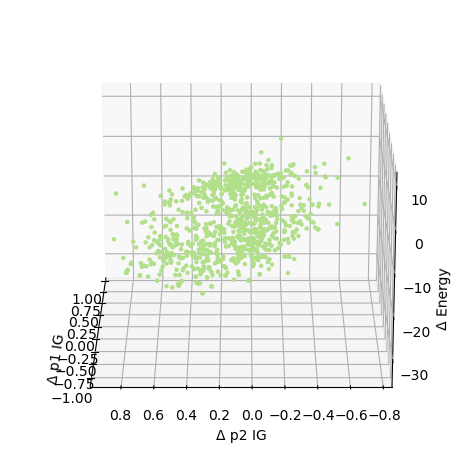

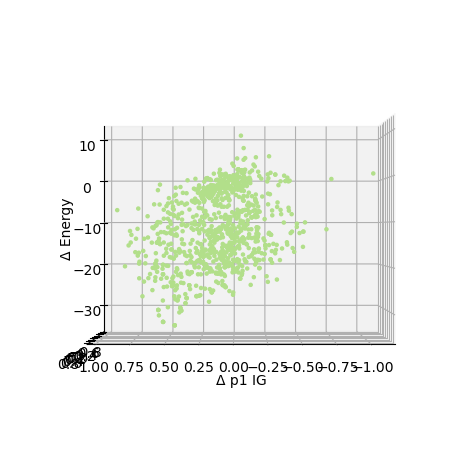

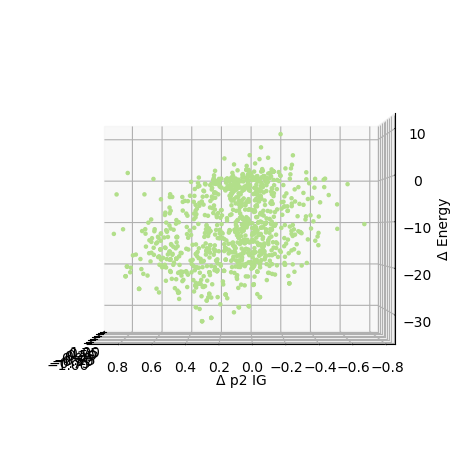

In [98]:
%matplotlib inline
get_3D_2mut_plot(mut2_1adq_loos_igs, 'mut2_1adq_loos_igs' )

In [99]:
print(get_corr(mut2_1nsn_loos_igs,['posn1 delta IG', 'dEnergy']))
print(get_corr(mut2_1nsn_loos_igs,['posn2 delta IG', 'dEnergy']))

-0.28
-0.26


In [100]:
reg = LinearRegression()
X = mut2_1nsn_loos_igs[['posn1 delta IG', 'posn2 delta IG']]
y = mut2_1nsn_loos_igs['dEnergy']
reg.fit(X,y)
print(reg.coef_)

[-13.16979714 -14.92426165]


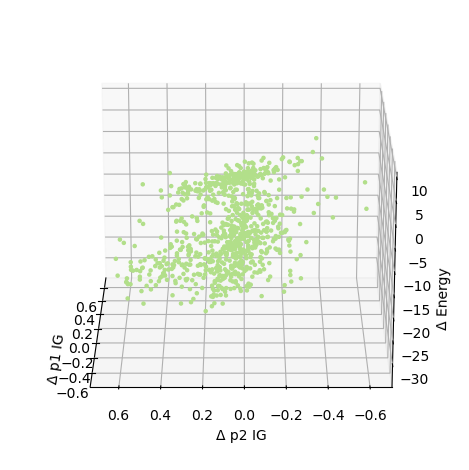

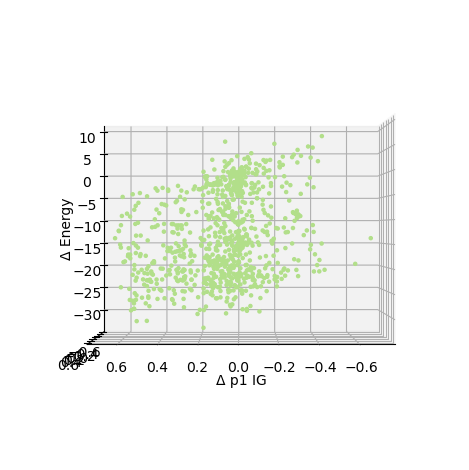

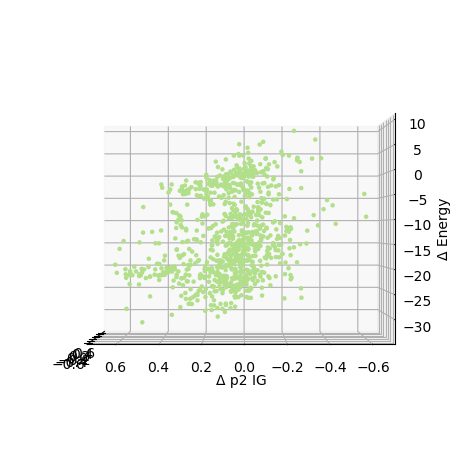

In [101]:
%matplotlib inline
get_3D_2mut_plot(mut2_1nsn_loos_igs, 'mut2_1nsn_loos_igs')

In [102]:
print(get_corr(mut2_1adq_low_igs,['posn1 delta IG', 'dEnergy']))
print(get_corr(mut2_1adq_low_igs,['posn2 delta IG', 'dEnergy']))

-0.29
-0.32


In [103]:
reg = LinearRegression()
X = mut2_1adq_low_igs[['posn1 delta IG', 'posn2 delta IG']]
y = mut2_1adq_low_igs['dEnergy']
reg.fit(X,y)
print(reg.coef_)

[ -8.5201599  -10.00256347]


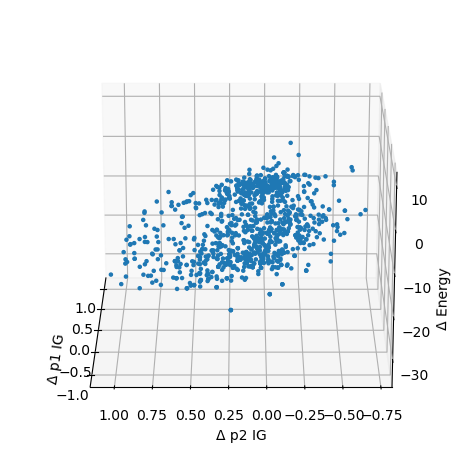

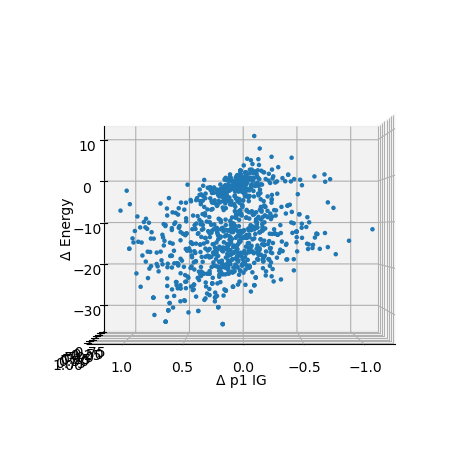

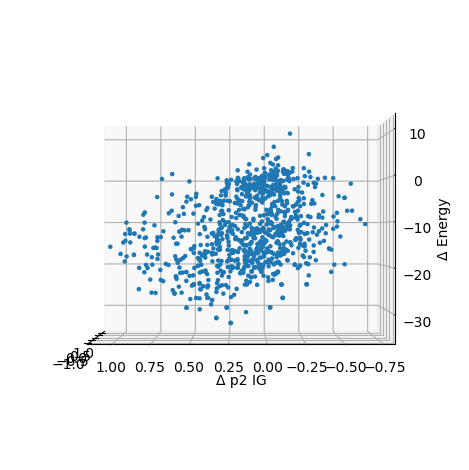

In [104]:
%matplotlib inline
get_3D_2mut_plot(mut2_1adq_low_igs, 'mut2_1adq_low_igs')

In [105]:
print(get_corr(mut2_1nsn_low_igs,['posn1 delta IG', 'dEnergy']))
print(get_corr(mut2_1nsn_low_igs,['posn2 delta IG', 'dEnergy']))

-0.32
-0.29


In [106]:
reg = LinearRegression()
X = mut2_1nsn_low_igs[['posn1 delta IG', 'posn2 delta IG']]
y = mut2_1nsn_low_igs['dEnergy']
reg.fit(X,y)
print(reg.coef_)

[-12.26568641 -13.2598453 ]


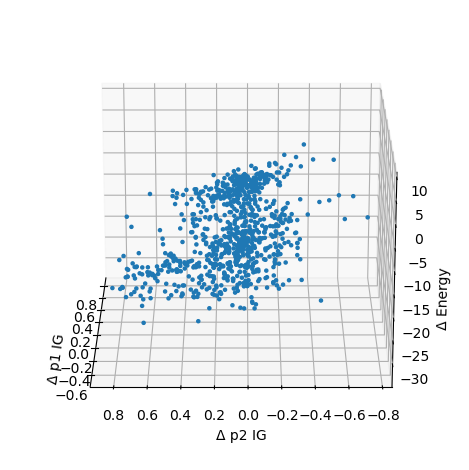

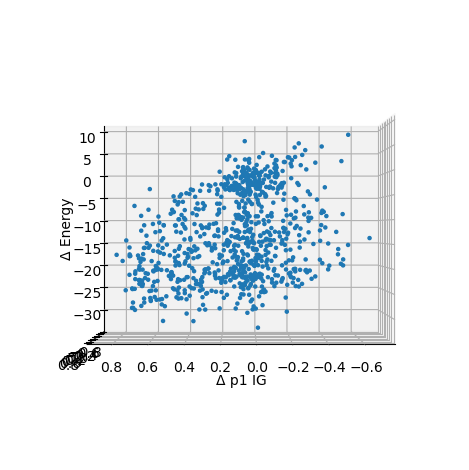

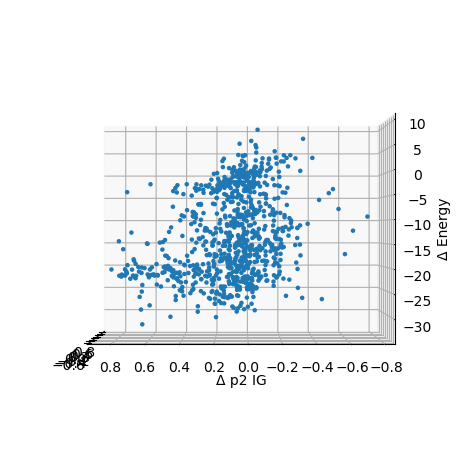

In [107]:
%matplotlib inline
get_3D_2mut_plot(mut2_1nsn_low_igs, 'mut2_1nsn_low_igs')

In [108]:
print(get_corr(mut2_1adq_igs,['posn1 delta IG', 'dEnergy']))
print(get_corr(mut2_1adq_igs,['posn2 delta IG', 'dEnergy']))

-0.05
0.03


In [109]:
reg = LinearRegression()
X = mut2_1adq_igs[['posn1 delta IG', 'posn2 delta IG']]
y = mut2_1adq_igs['dEnergy']
reg.fit(X,y)
print(reg.coef_)

[-2.50672844  1.07278183]


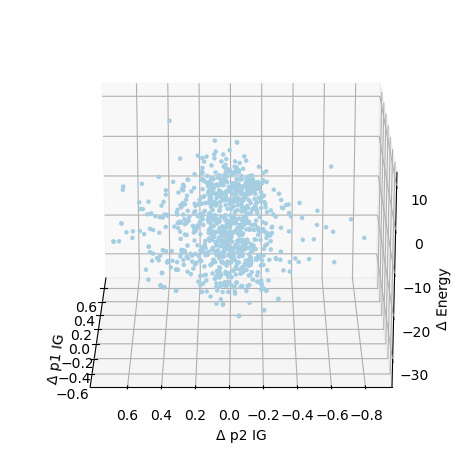

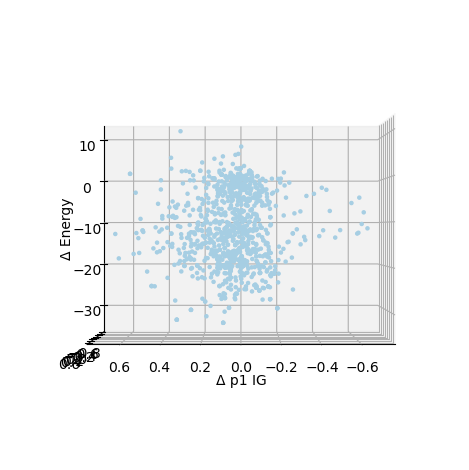

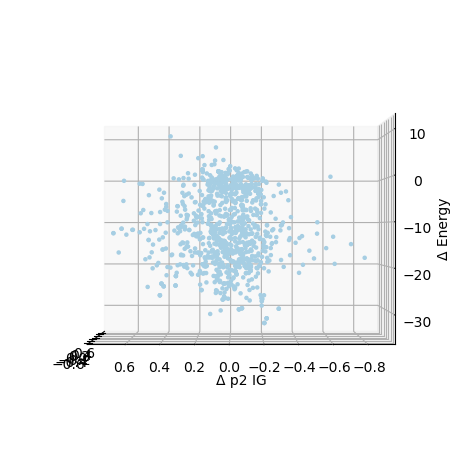

In [110]:
%matplotlib inline
get_3D_2mut_plot(mut2_1adq_igs, 'mut2_1adq_igs')

In [111]:
print(get_corr(mut2_1nsn_igs,['posn1 delta IG', 'dEnergy']))
print(get_corr(mut2_1nsn_igs,['posn2 delta IG', 'dEnergy']))

0.02
0.05


In [112]:
reg = LinearRegression()
X = mut2_1nsn_igs[['posn1 delta IG', 'posn2 delta IG']]
y = mut2_1nsn_igs['dEnergy']
reg.fit(X,y)
print(reg.coef_)

[0.81135656 1.76760016]


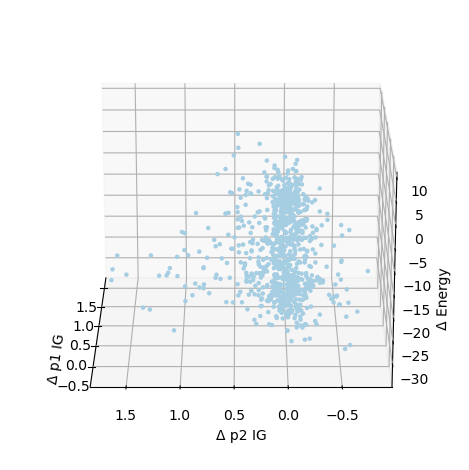

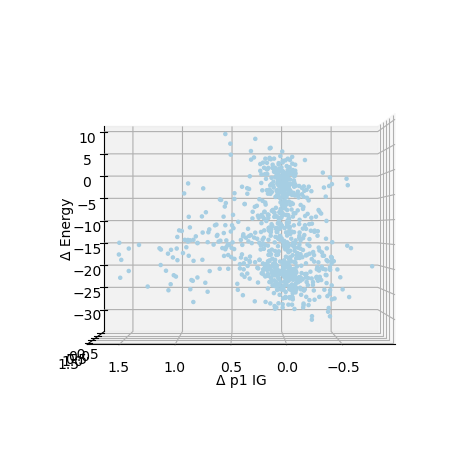

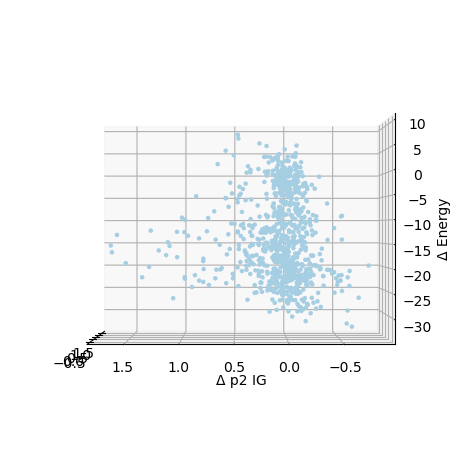

In [113]:
%matplotlib inline
get_3D_2mut_plot(mut2_1nsn_igs, 'mut2_1nsn_igs')